<a href="https://colab.research.google.com/github/Romuald2014/WATERFALL-PROJECT/blob/main/Waterfall_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waterfall Analysis of Sales Forecast Changes

### Introduction
- Objective: To investigate changes in forecast sales using a waterfall model.
- Dataset: Sales data with various stages and amounts.

### Data Loading and Initial Exploration
- **Load Data:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'deal_history.csv'
deal_history = pd.read_csv(file_path)

### Data Preparation

- **Data Type Conversion:**

In [ ]:
# Convert 'changed_at', 'closing_date' and 'created_date' to datetime
deal_history['changed_at'] = pd.to_datetime(deal_history['changed_at'], format='%d/%m/%Y')
deal_history['closing_date'] = pd.to_datetime(deal_history['closing_date'], format='%d/%m/%Y')
deal_history['created_date'] = pd.to_datetime(deal_history['created_date'], format='%d/%m/%Y')

### Creating Necessary Functions And Variables

In [ ]:
def get_last_deals_before_date(deal_history_df, filter_date):
    """
    This function filters the deal history to keep only the last deal for each deal_id before the given filter date
    and with closing_date within a 3-month window after the filter_date.
    """

    # Sort the dataframe by 'deal_id' and 'changed_at'
    deal_history_sorted = deal_history_df.sort_values(by=['deal_id', 'changed_at'])

    # Keep only the last deal before the filter date for each deal_id
    last_deals_before_date = deal_history_sorted[deal_history_sorted['changed_at'] <= filter_date].drop_duplicates(subset=['deal_id'], keep='last')

    # Filter deals with closing_date within 3 months after filter_date
    three_months_after = filter_date + pd.DateOffset(months=3)
    filtered_deals = last_deals_before_date[(last_deals_before_date['closing_date'] >= filter_date) &
                                            (last_deals_before_date['closing_date'] <= three_months_after)]

    return filtered_deals


def update_deals_parameters(deals_out, deal_history, end_date):
    """
    This function updates the stage, closing_date, and changed_at of deals in deals_out based on the latest
    information from the deal_history DataFrame before the given end_date.

    Parameters:
    deals_out (DataFrame): DataFrame containing deals that are in the start_pipeline but not in the end_pipeline.
    deal_history (DataFrame): DataFrame containing the full history of deals.
    end_date (str): The end date to filter the deal history by in 'YYYY-MM-DD' format.

    Returns:
    DataFrame: Updated deals_out DataFrame with parameters from the deal_history.
    """

    # Filter deal history to get the latest updates before the end_date for each deal_id
    latest_updates = deal_history[deal_history['changed_at'] <= end_date].sort_values(by=['deal_id', 'changed_at'])
    latest_updates = latest_updates.drop_duplicates(subset=['deal_id'], keep='last')

    # Merge deals_out with latest_updates to get updated parameters
    updated_deals_out = deals_out.merge(latest_updates[['deal_id', 'stage', 'closing_date', 'changed_at']],
                                        on='deal_id',
                                        suffixes=('_start', '_end'),
                                        how='left')

    # Update the parameters with the values from the latest_updates
    updated_deals_out['stage'] = updated_deals_out['stage_end'].combine_first(updated_deals_out['stage_start'])
    updated_deals_out['closing_date'] = updated_deals_out['closing_date_end'].combine_first(updated_deals_out['closing_date_start'])
    updated_deals_out['changed_at'] = updated_deals_out['changed_at_end'].combine_first(updated_deals_out['changed_at_start'])

    # Drop the temporary columns used for merging
    updated_deals_out.drop(columns=['stage_start', 'stage_end', 'closing_date_start', 'closing_date_end', 'changed_at_start', 'changed_at_end'], inplace=True)

    return updated_deals_out



# Function to format numbers as currency
def usd_currency_format(num):
    """Format number as currency with usd sign"""
    return f"${num:,.0f}"

# List of stages that are considered not active
not_active_stages = ['Closed Won', 'Closed Lost']

### Analysis and Сharting
- **Defining Start and End Pipeline Dates:**

In [ ]:
# Define Start Pipeline and End Pipeline Dates
start_date = pd.to_datetime("2024-05-05")
end_date = pd.to_datetime("2024-05-20")

- **Identifying Deal Categories and Calculating Sum:**

In [ ]:
# Get pipelines
start_pipeline = get_last_deals_before_date(deal_history, start_date)
end_pipeline = get_last_deals_before_date(deal_history, end_date)

# Exclude deals from start_pipeline based on not_active_stages
start_pipeline = start_pipeline[~start_pipeline['stage'].isin(not_active_stages)].copy()

# Identify and categorize deals_in
deals_in = end_pipeline[~end_pipeline['deal_id'].isin(start_pipeline['deal_id'])].copy()

# Split deals_in based on it's origin
new_deals = deals_in[(deals_in['created_date'] >= start_date) & (deals_in['created_date'] <= end_date)].copy()
pulled_deals = deals_in[~deals_in['deal_id'].isin(new_deals['deal_id'])].copy()

# Identify deals_out
deals_out = start_pipeline[~start_pipeline['deal_id'].isin(end_pipeline['deal_id'])].copy()

# Upddate deals_out with values in the end_date
deals_out = update_deals_parameters(deals_out, deal_history, end_date)

# Identify won deals from deals_out
deals_out_won = deals_out[deals_out['stage'] == 'Closed Won'].copy()

# Identify lost deals from deals_out
deals_out_lost = deals_out[deals_out['stage'] == 'Closed Lost'].copy()

# Identify the rest deals as pushed out
deals_out_pushed = deals_out[~deals_out['deal_id'].isin(deals_out_won['deal_id']) & ~deals_out['deal_id'].isin(deals_out_lost['deal_id'])]

# Identify increased amount deals
increased_amount_deals = start_pipeline.merge(
    end_pipeline[['deal_id', 'amount']],
    on='deal_id',
    how='inner',
    suffixes=('_start', '_end')
).loc[lambda x: x['amount_end'] > x['amount_start']]

# Identify decreased amount deals
decreased_amount_deals = start_pipeline.merge(
    end_pipeline[['deal_id', 'amount']],
    on='deal_id',
    how='inner',
    suffixes=('_start', '_end')
).loc[lambda x: x['amount_end'] < x['amount_start']]

# Identify deals in end_pipeline with stage "Closed Won" and move them to deals_out_won
end_pipeline_won = end_pipeline[end_pipeline['stage'] == 'Closed Won']

# Identify deals in end_pipeline with stage "Closed Lost" and move them to deals_out_won
end_pipeline_lost = end_pipeline[end_pipeline['stage'] == 'Closed Lost']

# Concatenate deals won
deals_won = pd.concat([deals_out_won, end_pipeline_won], ignore_index=True)

# Concatenate deals lost
deals_lost = pd.concat([deals_out_lost, end_pipeline_lost], ignore_index=True)

# Remove these deals from end_pipeline
end_pipeline = end_pipeline[~end_pipeline['deal_id'].isin(pd.concat([deals_won, deals_lost])['deal_id'])]

# Calculate the sums of amount for the waterfall chart
start_pipeline_sum = start_pipeline['amount'].sum()
new_deals_sum = new_deals['amount'].sum()
pulled_deals_sum = pulled_deals['amount'].sum()
deals_won_sum = -deals_won['amount'].sum()
deals_lost_sum = -deals_lost['amount'].sum()
deals_out_pushed_sum = -deals_out_pushed['amount'].sum()
increased_amount_sum = increased_amount_deals['amount_end'].sum() - increased_amount_deals['amount_start'].sum()
decreased_amount_sum = -decreased_amount_deals['amount_start'].sum() + decreased_amount_deals['amount_end'].sum()
end_pipeline_sum = end_pipeline['amount'].sum()

- **Drawing Waterfall Chart:**

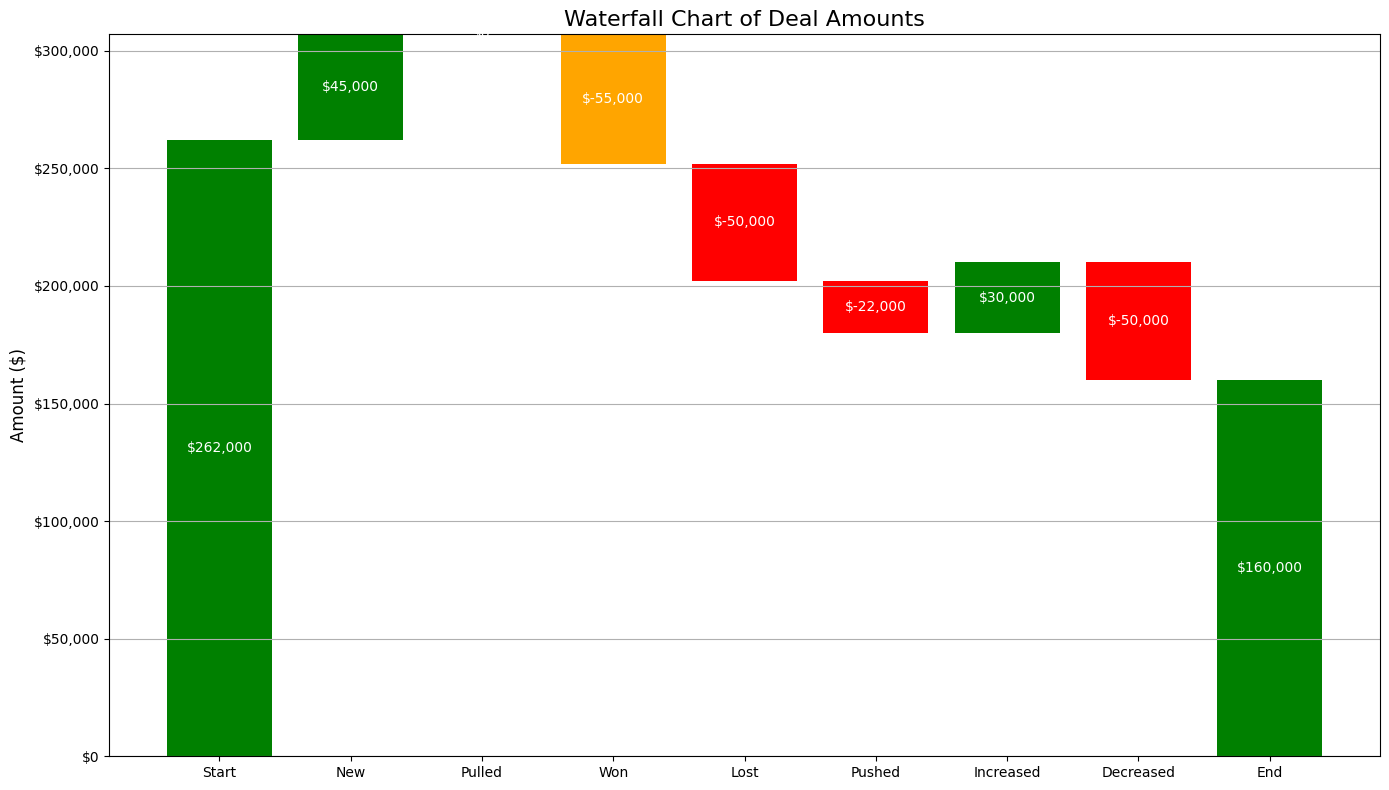

In [ ]:
# Adjust waterfall values and labels to include the new categories
waterfall_values = [
    start_pipeline_sum,
    new_deals_sum,
    pulled_deals_sum,
    deals_won_sum,
    deals_lost_sum,
    deals_out_pushed_sum,
    increased_amount_sum,
    decreased_amount_sum,
    end_pipeline_sum
]
cumulative = [0] + [sum(waterfall_values[:i+1]) for i in range(len(waterfall_values)-1)]
cumulative[-1] = 0  # Set the base of the last bar to 0

# Update labels
labels = ['Start', 'New', 'Pulled', 'Won', 'Lost', 'Pushed', 'Increased', 'Decreased', 'End']

# Create the waterfall chart with adjusted positions and formatted numbers
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(labels, waterfall_values, bottom=cumulative, align='center', color=['green', 'green', 'green', 'orange', 'red', 'red', 'green', 'red', 'green'])

# Displaying values on bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, cumulative[i] + yval/2, usd_currency_format(yval), ha='center', va='center', fontsize=10, color='white')

# Setting the title, labels, and tick formatting
ax.set_title('Waterfall Chart of Deal Amounts', fontsize=16)
ax.set_ylabel('Amount ($)', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: usd_currency_format(x)))
ax.grid(axis='y')

# Display the chart
plt.tight_layout()
plt.show()